# 3D skeleton tracking

Here we will create a 3d skeleton using OpenPifPaf to have the coordinates in the image coordinates and use the depth capacities of the intel Realsens d455 to add depth (3rd dimension).

Note: it's fairly important to use the included usb cable as others cables mignt not be recognized as usb 3.x. This is required in order to have everything working out smoothly.

In [1]:
import io
import numpy as np
import PIL
import torch
import openpifpaf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from timeit import timeit
from time import time
import os
import cv2
import pyrealsense2 as rs
import math as m

#### check version and available hardware

In [2]:
print('OpenPifPaf version', openpifpaf.__version__)
print('PyTorch version', torch.__version__)

OpenPifPaf version 0.13.11
PyTorch version 1.13.1+cu116


In [3]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
NVIDIA GeForce RTX 4070 Ti


#### Openpifpaf predictor

In [4]:
predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k16') #could use mobilenetv3small for betterperformances

#### Magic numbers and dicts

#### Utils

In [5]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def compute_angle(shoudler, hip, elbow):
    """ Returns the angle in radiants between of the arm defined by its shoudler, hip and elbow"""
    v1 = unit_vector(hip - shoudler)
    v2 = unit_vector(elbow - shoudler)
    return np.arccos(np.clip(np.dot(v1, v2),-1.0,1.0))*360/(2*np.pi)

  
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def compute_angle(shoudler, hip, elbow):
    """ Returns the angle in radiants between of the arm defined by its shoudler, hip and elbow"""
    v1 = unit_vector(hip - shoudler)
    v2 = unit_vector(elbow - shoudler)
    return np.arccos(np.clip(np.dot(v1, v2),-1.0,1.0))*360/(2*np.pi)

def compute_arms_angle(prediction):
    """ Returns the angle of left and right arm wrt to the torso (return nan if the arm is not seen) """
    
    pos_dict = {
        "nose": 0,
        "left_eye": 1,
        "right_eye": 2,
        "left_ear": 3,
        "right_ear": 4,
        "left_shoudler": 5,
        "right_shoudler": 6,
        "left_elbow": 7,
        "right_elbow": 8,
        "left_wrist": 9,
        "right_wrist": 10,
        "left_hip": 11,
        "right_hip": 12,
        "left_knee": 13,
        "right_knee": 14,
        "left_ankle": 15,
        "right_ankle": 16}
    
    # we suppose only on person on the image (index = 0)
    keypoints = predictions[0].data

    # left arm
    left_shoulder = keypoints[pos_dict["left_shoudler"],0:2]
    left_hip = keypoints[pos_dict["left_hip"],0:2]
    left_elbow = keypoints[pos_dict["left_elbow"],0:2]

    # right arm
    right_shoulder = keypoints[pos_dict["right_shoudler"],0:2]
    right_hip = keypoints[pos_dict["right_hip"],0:2]
    right_elbow = keypoints[pos_dict["right_elbow"],0:2]

    return(compute_angle(left_shoulder, left_hip, left_elbow), compute_angle(right_shoulder, right_hip, right_elbow))

def angles_to_command(left_angle, right_angle):
    """Returns the command corresponding to arms angle"""
    
    up_angle = 160
    horizontal_angle = 90
    down_angle = 20
    margin = 15

    # backward angle = 160 +/- 10
    if (left_angle > up_angle-margin and left_angle < up_angle+margin) and (right_angle > up_angle-margin and right_angle < up_angle+margin):
        return "backward"
    # forward angle = 90 +/- 10
    if (left_angle > horizontal_angle-margin and left_angle < horizontal_angle+margin) and (right_angle > horizontal_angle-margin and right_angle < horizontal_angle+margin):
        return "forward"
    # left = left: 90 +/- 10 right: 20 +/- 10
    if (left_angle > horizontal_angle-margin and left_angle < horizontal_angle+margin) and (right_angle > down_angle-margin and right_angle < down_angle+margin):
        return "left"
    # right = left: 20 +/- 10 right: 90 +/- 10
    if (left_angle > down_angle-margin and left_angle < down_angle+margin) and (right_angle > horizontal_angle-margin and right_angle < horizontal_angle+margin):
        return "right"
    else:
        return "stop"

In [6]:
def cart2sph(x,y,z):
    XsqPlusYsq = x**2 + y**2
    r = m.sqrt(XsqPlusYsq + z**2)               # r
    elev = m.atan2(z,m.sqrt(XsqPlusYsq))     # theta
    az = m.atan2(y,x)                           # phi
    return r, elev, az

def rad2deg(rad):
    return rad*180/m.pi

In [7]:
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)

In [28]:
RED = (0, 0, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)
YELLOW = (0, 255, 255)

pos_dict = {
        "nose": 0,
        "left_eye": 1,
        "right_eye": 2,
        "left_ear": 3,
        "right_ear": 4,
        "left_shoulder": 5,
        "right_shoulder": 6,
        "left_elbow": 7,
        "right_elbow": 8,
        "left_wrist": 9,
        "right_wrist": 10,
        "left_hip": 11,
        "right_hip": 12,
        "left_knee": 13,
        "right_knee": 14,
        "left_ankle": 15,
        "right_ankle": 16}

link_dict = {
        "nose": [("nose", "left_eye"),("nose", "right_eye")],
        "left_eye": [("left_eye", "left_ear")],
        "right_eye": [("right_eye", "right_ear")],
        "left_shoulder": [("left_shoulder", "left_elbow"),("left_shoulder", "left_hip"),("left_shoulder", "right_shoulder")],
        "right_shoulder": [("right_shoulder", "right_elbow"),("right_shoudler", "right_hip")],
        "left_elbow": [("left_elbow", "left_wrist")],
        "right_elbow": [("right_elbow", "right_wrist")],
        "left_hip": [("left_hip", "left_knee"),("left_hip", "right_hip"),("left_hip", "left_shoulder")],
        "right_hip": [("right_hip", "right_knee")],
        "left_knee": [("left_knee", "left_ankle")],
        "right_knee": [("right_knee", "right_ankle")]}



In [9]:
test = [("nose", "left_eye")]
len(test)

1

In [10]:
def display_whole_skeleton(keypoints, frame, pos_dict = pos_dict, link_dict = link_dict):
    for key in pos_dict:
        try:
            keypoint = keypoints[pos_dict[key],0:2]
            cv2.circle(frame, tuple(map(int, tuple(keypoint))), 5, RED, -1)
            try:
                links = link_dict[key]
                if len(links) > 1:
                    for link in links:
                            print(link)
                            keypoint1 = keypoints[pos_dict[link[0]],0:2]
                            keypoint2 = keypoints[pos_dict[link[1]],0:2]
                            cv2.line(frame, tuple(map(int, tuple(keypoint1))), tuple(map(int, tuple(keypoint2))), RED, 2)
                else:
                    print(links)
                    keypoint1 = keypoints[pos_dict[links[0][0]],0:2]
                    keypoint2 = keypoints[pos_dict[links[0][1]],0:2]
                    cv2.line(frame, tuple(map(int, tuple(keypoint1))), tuple(map(int, tuple(keypoint2))), RED, 2)
            except:
                continue
        except:
            continue

In [26]:
IMG_PATH = "Images/"
pil_im = PIL.Image.open((IMG_PATH+"shrek.JPG")).convert('RGB')
im = np.asarray(pil_im)
predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k16') #could use mobilenetv3small for betterperformances
predictions, gt_anns, image_meta = predictor.pil_image(pil_im)
keypoints = predictions[0].data

('nose', 'left_eye')
('nose', 'right_eye')
[('left_eye', 'left_ear')]
[('right_eye', 'right_ear')]
('left_shoulder', 'left_elbow')
('left_shoulder', 'left_hip')
('left_shoulder', 'right_shoulder')
('right_shoulder', 'right_elbow')
('right_shoudler', 'right_hip')
[('left_elbow', 'left_wrist')]
[('right_elbow', 'right_wrist')]
('left_hip', 'left_knee')
('left_hip', 'right_hip')
[('right_hip', 'right_knee')]
[('left_knee', 'left_ankle')]
[('right_knee', 'right_ankle')]


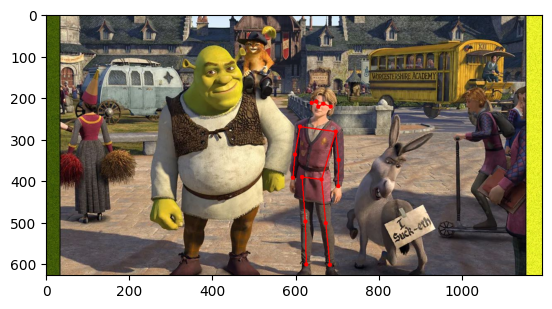

In [29]:
im = cv2.imread(IMG_PATH+"shrek.JPG")
display_whole_skeleton(keypoints, im)
cv2_imshow(im)

In [13]:
pipeline = rs.pipeline()
config = rs.config()

In [14]:
# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

In [15]:
print(device)

<pyrealsense2.device: Intel RealSense D455 (S/N: 141322250607  FW: 05.14.00.00  on USB3.2)>


In [16]:
found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)


In [17]:
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

if device_product_line == 'L500':
    config.enable_stream(rs.stream.color, 960, 540, rs.format.bgr8, 30)
else:
    config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)


In [21]:
pipeline.stop()

In [18]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [23]:
# Start streaming
#pipeline.stop()
cfg = pipeline.start(config)

debug = False
detection = True 

colorizer = rs.colorizer()

profile = cfg.get_stream(rs.stream.depth) # Fetch stream profile for depth stream
intr = profile.as_video_stream_profile().get_intrinsics() # Downcast to video_stream_profile and fetch intrinsics

while True:

    c = cv2.waitKey(1)
    if c == 27: # press escape to quit
        break

    # Wait for a coherent pair of frames: depth and color
    frames = pipeline.wait_for_frames()

    # Create alignment primitive with color as its target stream:
    align = rs.align(rs.stream.color)
    frameset = align.process(frames)

    # get aligned frames
    depth_frame = frameset.get_depth_frame()
    color_frame = frameset.get_color_frame()
    if not depth_frame or not color_frame:
        continue

    # Convert images to numpy arrays
    depth_image = np.asanyarray(depth_frame.get_data())
    color_image = np.asanyarray(color_frame.get_data())
    
    
    # ==== OPENPIFPAF =====
    if detection:
        # img = cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB)
        pil_img = PIL.Image.fromarray(color_image)
        frame = color_image

        predictions, _, _ = predictor.pil_image(pil_img)

        if debug:
            print(f"Angle of the left arm : {left_angle}\nAngle of the right arm : {right_angle}\n")

        try:
            left_angle, right_angle = compute_arms_angle(predictions)

            # writes desired command
            command = angles_to_command(left_angle, right_angle)
            # cv2.putText(img = frame, text=f"command: {command}", org = (0,60), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=GREEN,thickness=3)
            
            # ==== skeleton drawing ====
            #draw arms and hips
            keypoints = predictions[0].data

            display_whole_skeleton(keypoints, frame)
            # ==== END skeleton drawing ====

        except:
            cv2.putText(img = frame, text=f"no detection", org = (0,60), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=GREEN,thickness=2)

    # ==== END OPENPIFPAF =====
    
    # Update color and depth frames:
    aligned_depth_frame = frameset.get_depth_frame()
    colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

    # Show the two frames together:
    images = np.hstack((frame, colorized_depth))
    # plt.imshow(images)

    # Show images
    cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
    cv2.imshow('RealSense', images)
    cv2.waitKey(1)

# Stop streaming
pipeline.stop()

# Release resources
cv2.destroyAllWindows()

('nose', 'left_eye')
('nose', 'right_eye')
[('left_eye', 'left_ear')]
[('right_eye', 'right_ear')]
('left_shoulder', 'left_elbow')
('left_shoulder', 'left_hip')
('left_shoulder', 'right_shoulder')
('right_shoulder', 'right_elbow')
('right_shoudler', 'right_hip')
[('left_elbow', 'left_wrist')]
[('right_elbow', 'right_wrist')]
('left_hip', 'left_knee')
('left_hip', 'right_hip')
[('right_hip', 'right_knee')]
[('left_knee', 'left_ankle')]
[('right_knee', 'right_ankle')]
('nose', 'left_eye')
('nose', 'right_eye')
[('left_eye', 'left_ear')]
[('right_eye', 'right_ear')]
('left_shoulder', 'left_elbow')
('left_shoulder', 'left_hip')
('left_shoulder', 'right_shoulder')
('right_shoulder', 'right_elbow')
('right_shoudler', 'right_hip')
[('left_elbow', 'left_wrist')]
[('right_elbow', 'right_wrist')]
('left_hip', 'left_knee')
('left_hip', 'right_hip')
[('right_hip', 'right_knee')]
[('left_knee', 'left_ankle')]
[('right_knee', 'right_ankle')]
('nose', 'left_eye')
('nose', 'right_eye')
[('left_eye', '

C:\Users\eliot\AppData\Local\Temp\ipykernel_15224\3859969795.py:14: RuntimeWarning: invalid value encountered in divide
  return vector / np.linalg.norm(vector)


('nose', 'left_eye')
('nose', 'right_eye')
[('left_eye', 'left_ear')]
[('right_eye', 'right_ear')]
('left_shoulder', 'left_elbow')
('left_shoulder', 'left_hip')
('left_shoulder', 'right_shoulder')
('right_shoulder', 'right_elbow')
('right_shoudler', 'right_hip')
[('left_elbow', 'left_wrist')]
[('right_elbow', 'right_wrist')]
('left_hip', 'left_knee')
('left_hip', 'right_hip')
[('right_hip', 'right_knee')]
[('left_knee', 'left_ankle')]
[('right_knee', 'right_ankle')]
('nose', 'left_eye')
('nose', 'right_eye')
[('left_eye', 'left_ear')]
[('right_eye', 'right_ear')]
('left_shoulder', 'left_elbow')
('left_shoulder', 'left_hip')
('left_shoulder', 'right_shoulder')
('right_shoulder', 'right_elbow')
('right_shoudler', 'right_hip')
[('left_elbow', 'left_wrist')]
[('right_elbow', 'right_wrist')]
('left_hip', 'left_knee')
('left_hip', 'right_hip')
[('right_hip', 'right_knee')]
[('left_knee', 'left_ankle')]
[('right_knee', 'right_ankle')]
('nose', 'left_eye')
('nose', 'right_eye')
[('left_eye', '

In [ ]:
rs.deproject_pixel_to_point()